in this notebook: downscale the era5land temperatures to the 4 time-series per cell (using lapse rate) 
(take a mean elevation for each of the cells, create new 4 time-series)

create new-time-series with cellnr + a/b/c/d/ 

In [174]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os

Text(0.5, 1.0, 'era5land grid')

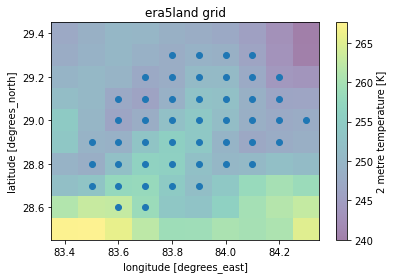

In [182]:
# test era5 land file
# era5land = xr.open_dataset('/Users/varyabazilova/Desktop/paper2/Thesisfiles_Varya/climate/Era5/langtang/temp/2022.nc')
# era5land = xr.open_dataset('/Users/varyabazilova/Desktop/paper2/Thesisfiles_Varya/climate/Era5/bagrot/temp/2022.nc')
era5land = xr.open_dataset('/Users/varyabazilova/Desktop/paper2/Thesisfiles_Varya/climate/Era5/mustang/temp/2022.nc')



# csv with coordinates and geopotential (z) 
# langtang_elevation = pd.read_csv('/Users/varyabazilova/Desktop/paper2/Thesisfiles_Varya/climate/elevation/geopotential_langtang.csv')
langtang_elevation = pd.read_csv('/Users/varyabazilova/Desktop/paper2/Thesisfiles_Varya/climate/elevation/geopotential_mustang.csv')

# plot together to see how points look
era5land.t2m.isel(time = 1).plot(alpha = 0.5)
plt.scatter(x = langtang_elevation.Longitude, y = langtang_elevation.Latitude)
plt.title('era5land grid')

In [183]:
langtang_elevation.columns

Index(['cellnr', 'Latitude', 'Longitude', 'z'], dtype='object')

In [184]:
# langtang_elevation

In [185]:
# dem 30m
# langtang dem - alluvial fans dem part 9
dempath = '/Users/varyabazilova/Desktop/alluvial_fans/dem_all/new_points_catchmetns/all_points/1_dem/'

dem_hma = xr.open_dataset(dempath + 'dem_clip.tif')
# clip using the langtang-ish bbox

# lon = x 
min_lon = era5land.longitude.values.min() - 0.05
max_lon = era5land.longitude.values.max() + 0.05

# lat = y
min_lat = era5land.latitude.values.min() - 0.05
max_lat = era5land.latitude.values.max() + 0.05

dem = dem_hma.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)


Text(0.5, 1.0, 'era5 land and dem together')

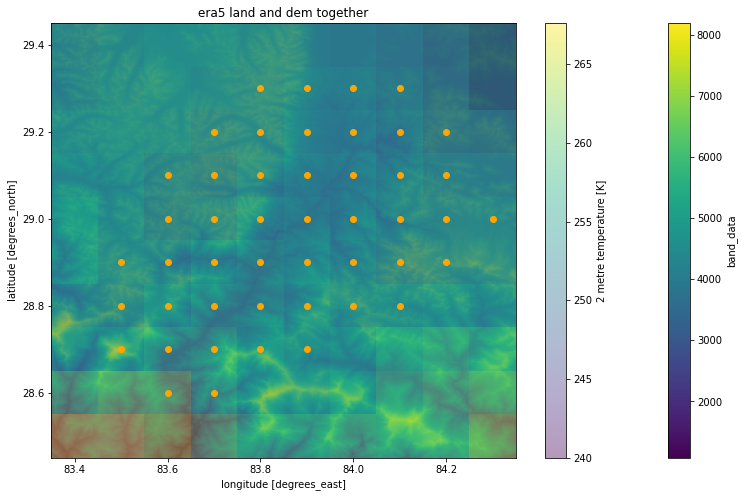

In [186]:
# plot dem together with points 
plt.figure(figsize = (13, 8))


dem.band_data.plot()
era5land.t2m.isel(time = 1).plot(alpha = 0.4)
plt.scatter(x = langtang_elevation.Longitude, y = langtang_elevation.Latitude, color = 'orange')

plt.title('era5 land and dem together')

## calculate the mean dem value per era5land pixel - xr.coarsen()

In [187]:
lat_len = len(era5land.latitude.values) *2 # y
lon_len = len(era5land.longitude.values) *2# x 

y_len = len(dem.y.values)
x_len = len(dem.x.values)

coarsened_dem = dem.coarsen(x=int(x_len/lon_len), y=int(y_len/lat_len), boundary='trim').median()

Text(0.5, 1.0, 'coarsened dem + era5 grid -> do they match?')

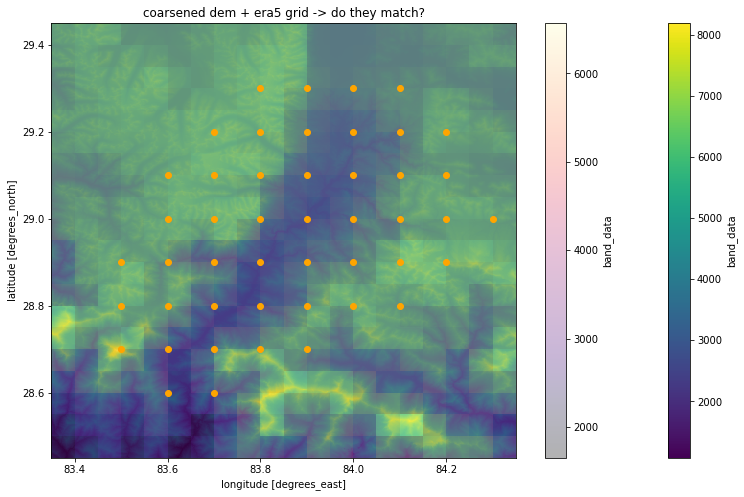

In [188]:
# plot all together to see of the grid matches

plt.figure(figsize = (13, 8))
dem.band_data.plot()
# era5land.t2m.isel(time = 1).plot(alpha = 0.3)
coarsened_dem.band_data.plot(cmap = 'magma', alpha = 0.3)
plt.scatter(x = langtang_elevation.Longitude, y = langtang_elevation.Latitude, color = 'orange')

plt.title('coarsened dem + era5 grid -> do they match?')

## make new points to get elevation from coarsened DEM 

In [189]:

df = langtang_elevation[['Longitude', 'Latitude']]

# Function to generate coordinates of 4 points around the middle of a square
def generate_points(row):
    x = row['Longitude']
    y = row['Latitude']
    points = [(x-0.025, y-0.025), (x+0.025, y-0.025), (x-0.025, y+0.025), (x+0.025, y+0.025)]  
    # Assuming each point represents the middle of a square and generate corners
    return pd.Series(points)

# Apply the function to each row
new_points = df.apply(generate_points, axis=1)

# Combine
result = pd.concat([df, new_points], axis=1)
result = result.melt(id_vars=['Longitude', 'Latitude'], value_name='point').drop(columns='variable')
result[['Longitude_new', 'Latitude_new']] = pd.DataFrame(result['point'].tolist(), index=result.index)

# Remove the original point
result = result[result['Longitude_new'] != result['Longitude']]
result = result[result['Latitude_new'] != result['Latitude']]

result

,Longitude,Latitude,point,Longitude_new,Latitude_new
0,83.6,28.6,"(83.57499999999999, 28.575000000000003)",83.575,28.575
1,83.7,28.6,"(83.675, 28.575000000000003)",83.675,28.575
2,83.5,28.7,"(83.475, 28.675)",83.475,28.675
3,83.6,28.7,"(83.57499999999999, 28.675)",83.575,28.675
4,83.7,28.7,"(83.675, 28.675)",83.675,28.675
...,...,...,...,...,...
183,84.2,29.2,"(84.22500000000001, 29.224999999999998)",84.225,29.225
184,83.8,29.3,"(83.825, 29.325)",83.825,29.325
185,83.9,29.3,"(83.92500000000001, 29.325)",83.925,29.325
186,84.0,29.3,"(84.025, 29.325)",84.025,29.325


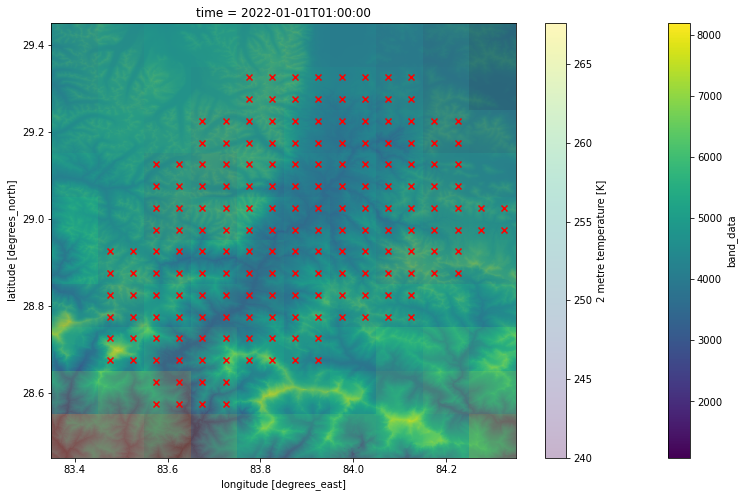

In [190]:
# plot all together to see of the grid matches

plt.figure(figsize = (13, 8))
dem.band_data.plot()
era5land.t2m.isel(time = 1).plot(alpha = 0.3)
# coarsened_dem.band_data.plot(cmap = 'magma', alpha = 0.3)
# plt.scatter(x = langtang_elevation.Longitude, y = langtang_elevation.Latitude, color = 'orange')
plt.scatter(x = result.Longitude_new, y = result.Latitude_new, marker = 'x', color = 'red')


In [191]:
result = result.merge(langtang_elevation, on = ['Longitude', 'Latitude'])

In [192]:
result

,Longitude,Latitude,point,Longitude_new,Latitude_new,cellnr,z
0,83.6,28.6,"(83.57499999999999, 28.575000000000003)",83.575,28.575,13,3197.314081
1,83.6,28.6,"(83.625, 28.575000000000003)",83.625,28.575,13,3197.314081
2,83.6,28.6,"(83.57499999999999, 28.625)",83.575,28.625,13,3197.314081
3,83.6,28.6,"(83.625, 28.625)",83.625,28.625,13,3197.314081
4,83.7,28.6,"(83.675, 28.575000000000003)",83.675,28.575,14,3815.073340
...,...,...,...,...,...,...,...
183,84.0,29.3,"(84.025, 29.325)",84.025,29.325,87,4559.334454
184,84.1,29.3,"(84.07499999999999, 29.275000000000002)",84.075,29.275,88,4777.921465
185,84.1,29.3,"(84.125, 29.275000000000002)",84.125,29.275,88,4777.921465
186,84.1,29.3,"(84.07499999999999, 29.325)",84.075,29.325,88,4777.921465


## make unique cellnr (Na/b/c/d)

In [193]:
label = result[['cellnr']]

def generate_labels(row):
    return ['a', 'b', 'c', 'd']

 # Generate labels for each group of 4 rows
labels = label.groupby('cellnr').apply(generate_labels).explode().reset_index(drop=True)

result['labels'] = labels
result['cellnr2'] = result['cellnr'].astype(str) + labels

In [194]:
# result.to_csv('coordinates_with_labels_mustang.csv', index = False)

## locate a b c and d points

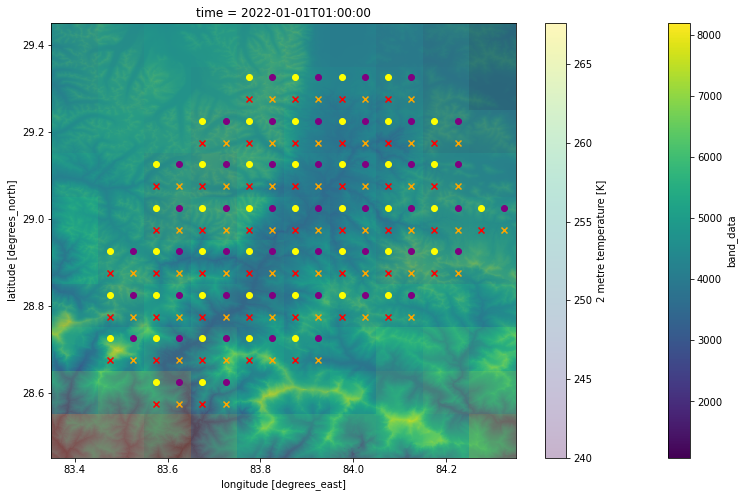

In [195]:
# only pick a points 
a  = result[result['labels'] == 'a']
b  = result[result['labels'] == 'b']
c  = result[result['labels'] == 'c']
d  = result[result['labels'] == 'd']


plt.figure(figsize = (13, 8))
dem.band_data.plot()
era5land.t2m.isel(time = 1).plot(alpha = 0.3)
plt.scatter(x = a.Longitude_new, y = a.Latitude_new, marker = 'x', color = 'red', label = 'a')
plt.scatter(x = b.Longitude_new, y = b.Latitude_new, marker = 'x', color = 'orange', label = 'b')
plt.scatter(x = c.Longitude_new, y = c.Latitude_new, marker = 'o', color = 'yellow', label = 'c')
plt.scatter(x = d.Longitude_new, y = d.Latitude_new, marker = 'o', color = 'purple', label = 'c')



## extract new elevation from DEM 

In [196]:
# langtang elevation - csv with z value for the geopotential 
longitudes = result.Longitude_new
latitudes = result.Latitude_new

selected = coarsened_dem.sel(x = longitudes, y = latitudes, method = 'nearest')

df = selected.to_dataframe()
df = df.reset_index()
df = df.drop_duplicates()
df = df.rename(columns = {'x':'Longitude_new', 'y':'Latitude_new'})

# # round so that coordinates match
result = result.round(3)
df = df.round(3)

In [197]:
merged = result.merge(df, on = ['Longitude_new', 'Latitude_new'])

# z - geopotential 
# band_data = dem data 
# delts H = difference between geopotential and DEM info
merged['delta_H'] = merged.z - merged.band_data 
merged['delta_t'] = merged.delta_H * 6.5/1000

In [198]:
# merged

In [199]:
# final table with cell number and delta temperature 

df = merged[['cellnr','cellnr2', 'delta_t']]


In [201]:
# df

### downscale the temperatures for each file as input

In [162]:
import os
import pandas as pd

# Specify the path to the folder containing climate files
climate_folder = '/Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate2'

# Step 1: Read the table data into a DataFrame
table_df = df

# Step 2: Iterate over each row in the DataFrame
for index, row in table_df.iterrows():
    cellnr = row['cellnr']
    delta_t = row['delta_t']
    cellnr2 = row['cellnr2']  # New column for generating filenames
    
    # Step 3: Read and update the corresponding file
    file_path = os.path.join(climate_folder, f'climatecell.{cellnr}.met')
    if os.path.exists(file_path):
        # Read the file into a DataFrame
        file_df = pd.read_csv(file_path)
        
        # Update Ta values for each group of four lines
        for i in range(0, len(file_df), 4):
            file_df.loc[i:i+3, 'Ta'] += delta_t
            
        # Save the updated DataFrame back to the file with appropriate filename
        new_file_path = os.path.join(climate_folder, f'climatefile.{cellnr2}.met')
        file_df.to_csv(new_file_path, index=False)
        print(f'Ta values updated and saved for {new_file_path}')
    else:
        print(f'File {file_path} not found.')

print('All updates complete.')


Ta values updated and saved for /Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate2/climatefile.12a.met
Ta values updated and saved for /Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate2/climatefile.12b.met
Ta values updated and saved for /Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate2/climatefile.12c.met
Ta values updated and saved for /Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate2/climatefile.12d.met
Ta values updated and saved for /Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate2/climatefile.13a.met
Ta values updated and saved for /Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate2/climatefile.13b.met
Ta values updated and saved for /Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate2/climatefile.13c.met
Ta values updated and saved for /Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate2/climatefile.13d.met


In [204]:
import os
import pandas as pd

# Specify the path to the folder containing climate files
# climate_folder = '/Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate2'
climate_folder = '/Users/varyabazilova/Desktop/paper2/downscaling_simple/mustang_climate'

# Step 1: Read the table data into a DataFrame
table_df = df

# Step 2: Iterate over each row in the DataFrame
for index, row in table_df.iterrows():
    cellnr = row['cellnr']
    delta_t = row['delta_t']
    cellnr2 = row['cellnr2']  # New column for generating filenames
    
    # Step 3: Read and update the corresponding file
    file_path = os.path.join(climate_folder, f'climatecell.{cellnr}.met')
    if os.path.exists(file_path):
        # Read the file into a DataFrame
        file_df = pd.read_csv(file_path)
        
        # Update Ta values for each group of four lines
        for i in range(0, len(file_df), 4):
            file_df.loc[i:i+3, 'Ta'] += delta_t
            
        # Create the folder 'cellnr2' if it doesn't exist
        save_folder = os.path.join(climate_folder, cellnr2)
        os.makedirs(save_folder, exist_ok=True)
        
        # Save the updated DataFrame to the file within the 'cellnr2' folder
        new_file_path = os.path.join(save_folder, f'climatefile.{cellnr2}.met')
        file_df.to_csv(new_file_path, index=False)
        print(f'Ta values updated and saved for {new_file_path}')
    else:
        print(f'File {file_path} not found.')

print('All updates complete.')


Ta values updated and saved for /Users/varyabazilova/Desktop/paper2/downscaling_simple/mustang_climate/13a/climatefile.13a.met
Ta values updated and saved for /Users/varyabazilova/Desktop/paper2/downscaling_simple/mustang_climate/13b/climatefile.13b.met
Ta values updated and saved for /Users/varyabazilova/Desktop/paper2/downscaling_simple/mustang_climate/13c/climatefile.13c.met
Ta values updated and saved for /Users/varyabazilova/Desktop/paper2/downscaling_simple/mustang_climate/13d/climatefile.13d.met
Ta values updated and saved for /Users/varyabazilova/Desktop/paper2/downscaling_simple/mustang_climate/14a/climatefile.14a.met
Ta values updated and saved for /Users/varyabazilova/Desktop/paper2/downscaling_simple/mustang_climate/14b/climatefile.14b.met
Ta values updated and saved for /Users/varyabazilova/Desktop/paper2/downscaling_simple/mustang_climate/14c/climatefile.14c.met
Ta values updated and saved for /Users/varyabazilova/Desktop/paper2/downscaling_simple/mustang_climate/14d/clim